In [1]:
import sys
sys.path.append('../algorithms')
sys.path.append('../datasets')

import torch

import matplotlib.pyplot as plt

from datasets import HSIDataset
from tvprior import TVPrior
from nabla import nabla

from torchvision import transforms
from math import sqrt


In [14]:
# Define device (default is "cpu")
device = "cuda"

# Define dtype
dtype = torch.float32

# Define random seed
seed = 42
torch.manual_seed(seed)

# Define data path
data_path = '/home/y/Documents/Data/HSI/hyspecnet-11k/datasets/hyspecnet-11k.zarr'


In [15]:
# Loads ENMAP Hypecnet Datasets 

val_transform = transforms.Compose([transforms.ToTensor()]) # Transforms a the input data to torch tensors
dataset = HSIDataset(root_dir=data_path, split='test', transform=val_transform)

# Choose the index of the selected image in the dataset (ENMAP dataset contains 11 000 images)
idx = 1131 
x = dataset[idx].unsqueeze(0).to(device=device, dtype=dtype) # import image to device (cpu or gpu), sizes of x is [1,number of bands, width, height]
# Adds a small amount of white gaussian noise to the input HSI (sigma2 = 1e-4)
x += 1e-2*torch.rand_like(x, device=device, dtype=dtype)

# Compute the panchromatic image from the ground truth HSI
panc = torch.sum(x, dim=1).unsqueeze(1)/x.shape[1]
grad_panc = nabla(panc)

# Adds noise to the input HSI
sigma2 = 0.001
y = x + sqrt(sigma2)*torch.randn_like(x, device=device, dtype=dtype)


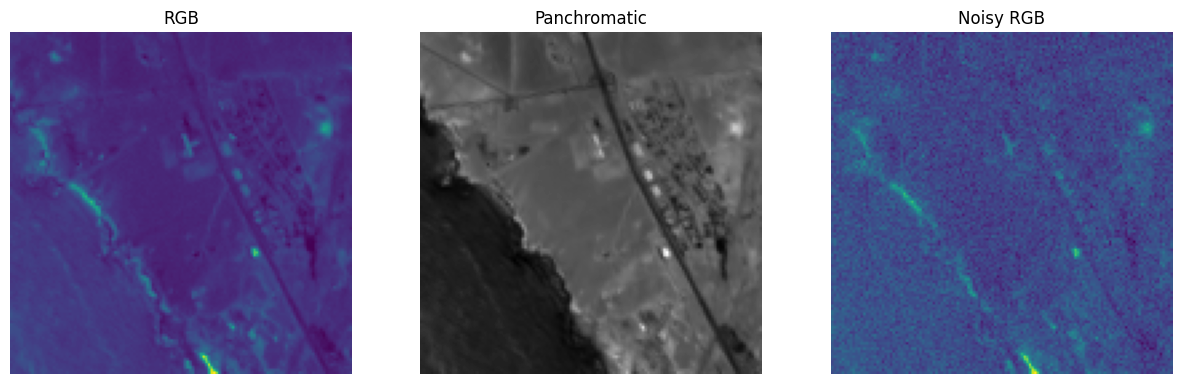

In [16]:
# Plot RGB and panchromatic 

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(x[0, 0, ...].cpu().numpy())
plt.title('RGB')
plt.axis('off')

plt.subplot(132)
plt.imshow(panc[0, 0, ...].cpu().numpy(), cmap='gray')
plt.title('Panchromatic')
plt.axis('off')

plt.subplot(133)
plt.imshow(y[0, 0, ...].cpu().numpy())
plt.title('Noisy RGB')
plt.axis('off')

plt.show()



In [19]:

# Define the solver parameters
params = {}

params['compute_L'] = {'nband': x.shape[1]}
params['K'] = {}
params['K_adjoint'] = {}
params['prox_sigma_g_conj'] = {}
params['prox_tau_f'] = {'y': y, 'sigma2': 1}
params['loss_fn'] = {}

sigma = 0.99
tau = 0.99
optim = TVPrior(max_iter=10000, lmbda=1e-2, theta=1, sigma=sigma, tau=tau)

x_est, loss = optim(y, init=None, verbose=True, params=params)

Chambolle Pock algorithm starting...
Iteration:  0 relative variation:  tensor(0.0010, device='cuda:0')
Cost function:  tensor(19856.0312)
Iteration:  1 relative variation:  tensor(0.0010, device='cuda:0')
Cost function:  tensor(19706.1172)
Iteration:  2 relative variation:  tensor(0.0010, device='cuda:0')
Cost function:  tensor(19558.8965)
Iteration:  3 relative variation:  tensor(0.0010, device='cuda:0')
Cost function:  tensor(19414.3242)
Iteration:  4 relative variation:  tensor(0.0010, device='cuda:0')
Cost function:  tensor(19272.3516)
Iteration:  5 relative variation:  tensor(0.0009, device='cuda:0')
Cost function:  tensor(19132.9199)
Iteration:  6 relative variation:  tensor(0.0009, device='cuda:0')
Cost function:  tensor(18995.9941)
Iteration:  7 relative variation:  tensor(0.0009, device='cuda:0')
Cost function:  tensor(18861.5176)
Iteration:  8 relative variation:  tensor(0.0009, device='cuda:0')
Cost function:  tensor(18729.4492)
Iteration:  9 relative variation:  tensor(0.0

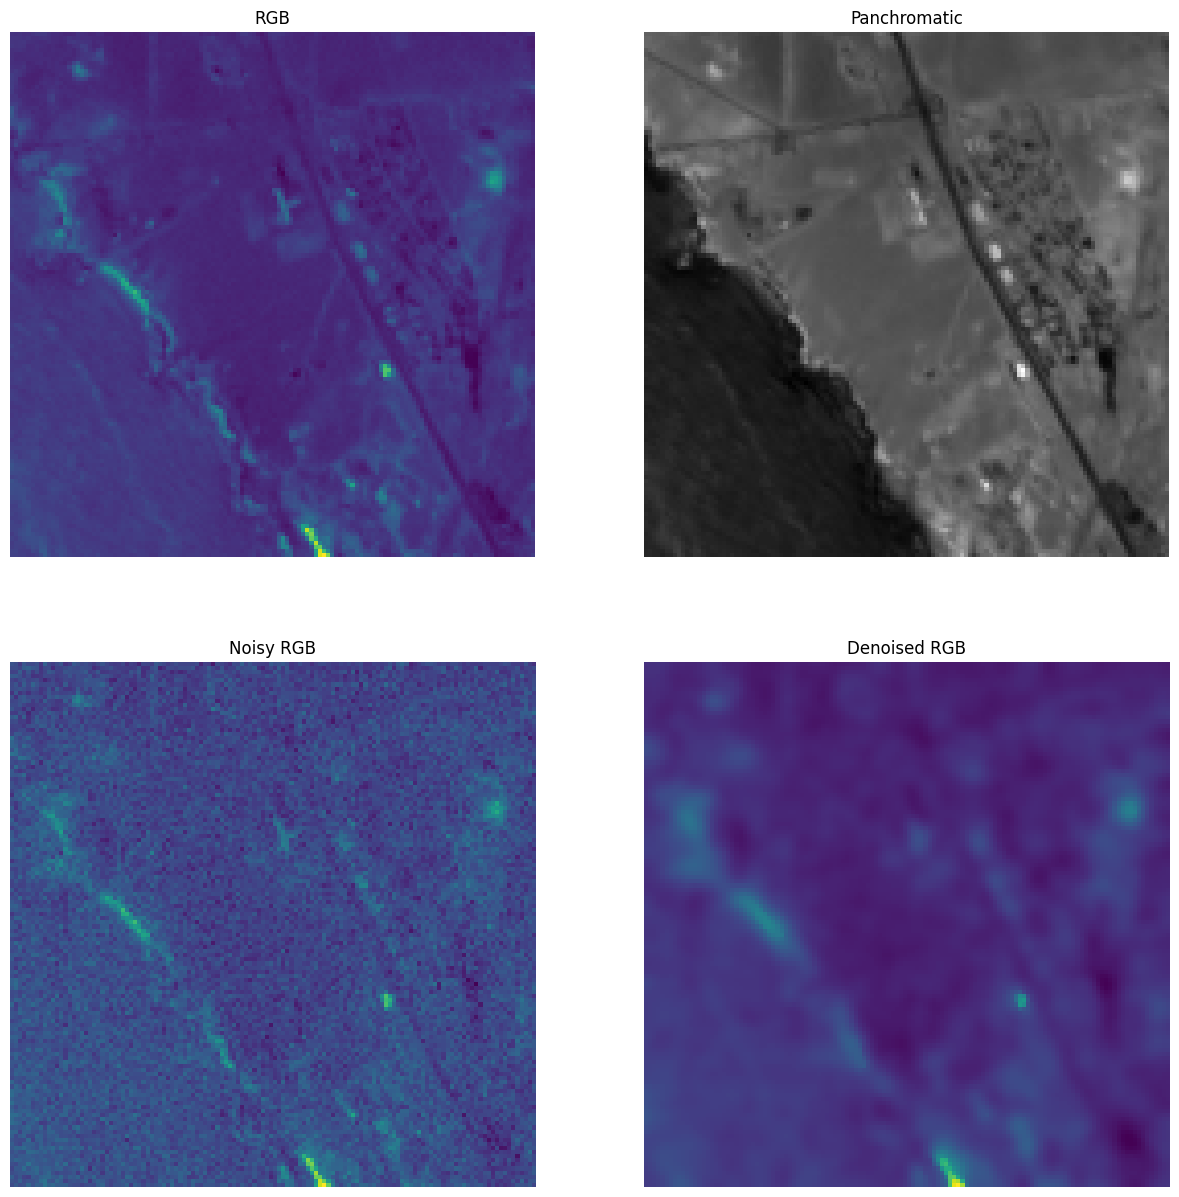

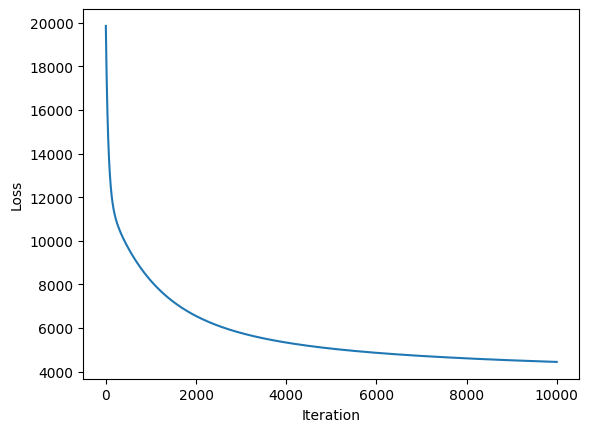

In [21]:
# Plot RGB and panchromatic 

plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.imshow(x[0, 0, ...].cpu().numpy())
plt.title('RGB')
plt.axis('off')

plt.subplot(222)
plt.imshow(panc[0, 0, ...].cpu().numpy(), cmap='gray')
plt.title('Panchromatic')
plt.axis('off')

plt.subplot(223)
plt.imshow(y[0, 0, ...].cpu().numpy())
plt.title('Noisy RGB')
plt.axis('off')

plt.subplot(224)
plt.imshow(x_est[0, 0, ...].cpu().numpy())
plt.title('Denoised RGB')
plt.axis('off')



plt.figure()
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()